# Exploratory Data Analysis

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from scipy.stats import spearmanr, f_oneway, chi2_contingency
from datetime import datetime

In [2]:
# file retrieval
df = pd.read_csv('../data/unlabelled_raw_data.csv')

## Data visualisation

In [3]:
# learn about my dataset
print(df.describe())

       rating_person  total_number_of_reviews_by_reviewer  \
count    3438.000000                          3438.000000   
mean        4.363874                            62.714951   
std         1.226916                           176.329915   
min         1.000000                             0.000000   
25%         4.000000                             3.000000   
50%         5.000000                            11.000000   
75%         5.000000                            41.000000   
max         5.000000                          3058.000000   

       total_number_of_photos_by_reviewer  is_local_guide  is_spending_on_ads  \
count                         3438.000000          1805.0                83.0   
mean                           323.361838             1.0                 1.0   
std                           1513.053468             0.0                 0.0   
min                              0.000000             1.0                 1.0   
25%                              0.000000    

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3438 entries, 0 to 3437
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   place_id                             3438 non-null   object 
 1   place_name                           3438 non-null   object 
 2   review_id                            3438 non-null   object 
 3   review_link                          3438 non-null   object 
 4   name_person                          3438 non-null   object 
 5   reviewer_id                          3438 non-null   object 
 6   reviewer_profile                     3438 non-null   object 
 7   rating_person                        3438 non-null   int64  
 8   review_text                          2610 non-null   object 
 9   published_at                         3438 non-null   object 
 10  published_at_date                    3438 non-null   object 
 11  response_from_owner_text      

In [5]:
print(df.head())

                      place_id                 place_name  \
0  ChIJU_Rb8VIZ2jER1wWC4e0_hXw  Paperbakes @ Raffles City   
1  ChIJU_Rb8VIZ2jER1wWC4e0_hXw  Paperbakes @ Raffles City   
2  ChIJU_Rb8VIZ2jER1wWC4e0_hXw  Paperbakes @ Raffles City   
3  ChIJU_Rb8VIZ2jER1wWC4e0_hXw  Paperbakes @ Raffles City   
4  ChIJU_Rb8VIZ2jER1wWC4e0_hXw  Paperbakes @ Raffles City   

                                           review_id  \
0  Ci9DQUlRQUNvZENodHljRjlvT25aUFRrcERUbEpVVVV3M0...   
1  Ci9DQUlRQUNvZENodHljRjlvT2sxeFRYTTFVRVpwV0VsbF...   
2  Ci9DQUlRQUNvZENodHljRjlvT2tOSFZXOHhZVVJJTlhkdl...   
3  Ci9DQUlRQUNvZENodHljRjlvT25SM01rWjZWeTE1ZFRaUV...   
4  Ci9DQUlRQUNvZENodHljRjlvT2tSVmNFaDFMVXhHY201VW...   

                                         review_link            name_person  \
0  https://www.google.com/maps/reviews/data=!4m8!...                TIFFANY   
1  https://www.google.com/maps/reviews/data=!4m8!...             Joyin Chio   
2  https://www.google.com/maps/reviews/data=!4m8!...       

### At a glance
Numeric data: `total_number_of_reviews_by_reviewer`, `total_number_of_photos_by_reviewer`, `reviews`, `rating_place`

Categorical data: `main_category`, `is_local_guide`, `is_spending_on_ads`, `can_claim`, `rating_person`, `rating_place`

Needs feature engineering: 
`review_text` - tfidf, ngrams,
`review_translated_text` - replace review_text when it exists and delete the column

Similar data: 
- `place_name` from reviews_df same as `name_place` from overview_df.
- `review_translated_text` is a translation to english of `review_text`, if `review_text` is not in english.
- `response_from_owner_translated_text` is a translation to english of `response_from_owner_text`, if `response_from_owner_text` is not in english.

Miscellaneous data:
- links, `phone` and `query` don't provide any insight for analysis.
- `is_temporarily_closed` is an empty column.
- `place_id`, `review_id` and `reviewer_id` are high-cardinality columns that are not useful as features.
- `name`, `name_person`, `owner_name` are just names of people or places and don't provide any insight for analysis, especially since we have `main_category`.

Tentative:
- `name_place`
- `response_from_owner_text` - needed?, `response_from_owner_translated_text` - replace response_from_owner_text when it exists and delete the column,
- `published_at`, `published_date` - make `published_ago` the no. of days since published date and delete these 2, 
- `response_from_owner_ago`, `response_from_owner_date` - convert response_from_owner_ago into the no. of days since the owner responded, 
- `experience_details` - has extra details but not sure if wanna complicate things by including.
- `description`, `competitors`, `workday_timing`, `closed_on`, `address`, `review_keywords`(could be categorical)
- `categories` - already have `main_category`

Current columns to use:
['review_text', 'rating_person', 'rating_place', 'total_number_of_reviews_by_reviewer', 'total_number_of_photos_by_reviewer', 'reviews', 'rating_place', 'is_local_guide', 'is_spending_on_ads', 'can_claim', 'main_category']

10 columns

Deal with similar data and miscellaneous data

In [6]:
# if review_translated_text is not empty, replace review_text with this
review_replace_mask = df['review_translated_text'].notna()
df.loc[review_replace_mask, 'review_text'] = df.loc[review_replace_mask, 'review_translated_text']

# if response_from_owner_translated_text is not empty, replace response_from_owner_text with this
response_replace_mask = df['response_from_owner_translated_text'].notna()
df.loc[response_replace_mask, 'response_from_owner_text'] = df.loc[response_replace_mask, 'response_from_owner_translated_text']

# drop columns
drop_cols = ['place_name', 'name_person', 'owner_name', 'query', 'review_translated_text', 
             'response_from_owner_translated_text', 'review_link', 'phone', 'link', 'website',
             'reviewer_profile', 'owner_profile_link', 'featured_image', 'review_photos',
             'link', 'is_temporarily_closed', 'place_id', 'review_id', 'reviewer_id']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors="ignore")

print(df.head())

   rating_person                                        review_text  \
0              5  The food here is really good and healthy, with...   
1              5  Came across this new outlet with surprisingly ...   
2              5  The flavors were perfectly balanced--savory, f...   
3              5  Simple to order via kiosk, signature chicken w...   
4              5  Had office lunch from paperbakes. The Whole Ch...   

  published_at    published_at_date response_from_owner_text  \
0   5 days ago  2025-08-20T04:53:37                      NaN   
1   6 days ago  2025-08-19T05:30:13                      NaN   
2   6 days ago  2025-08-19T03:33:21                      NaN   
3   a week ago  2025-08-18T04:11:57                      NaN   
4   a week ago  2025-08-15T09:01:47                      NaN   

  response_from_owner_ago response_from_owner_date  \
0                     NaN                      NaN   
1                     NaN                      NaN   
2                     NaN 

For numeric boolean data, need to convert NaN to 0 instead.
- is_local_guide
- is_spending_on_ads
- can_claim

In [7]:
# convert NaN to 0 for is_local_guide, is_spending_on_ads, can_claim
bool_cols = ["is_local_guide", "is_spending_on_ads", "can_claim"]
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype(int)

print(df.describe())

       rating_person  total_number_of_reviews_by_reviewer  \
count    3438.000000                          3438.000000   
mean        4.363874                            62.714951   
std         1.226916                           176.329915   
min         1.000000                             0.000000   
25%         4.000000                             3.000000   
50%         5.000000                            11.000000   
75%         5.000000                            41.000000   
max         5.000000                          3058.000000   

       total_number_of_photos_by_reviewer  is_local_guide  is_spending_on_ads  \
count                         3438.000000     3438.000000         3438.000000   
mean                           323.361838        0.525015            0.024142   
std                           1513.053468        0.499447            0.153512   
min                              0.000000        0.000000            0.000000   
25%                              0.000000    

### Reviewer information

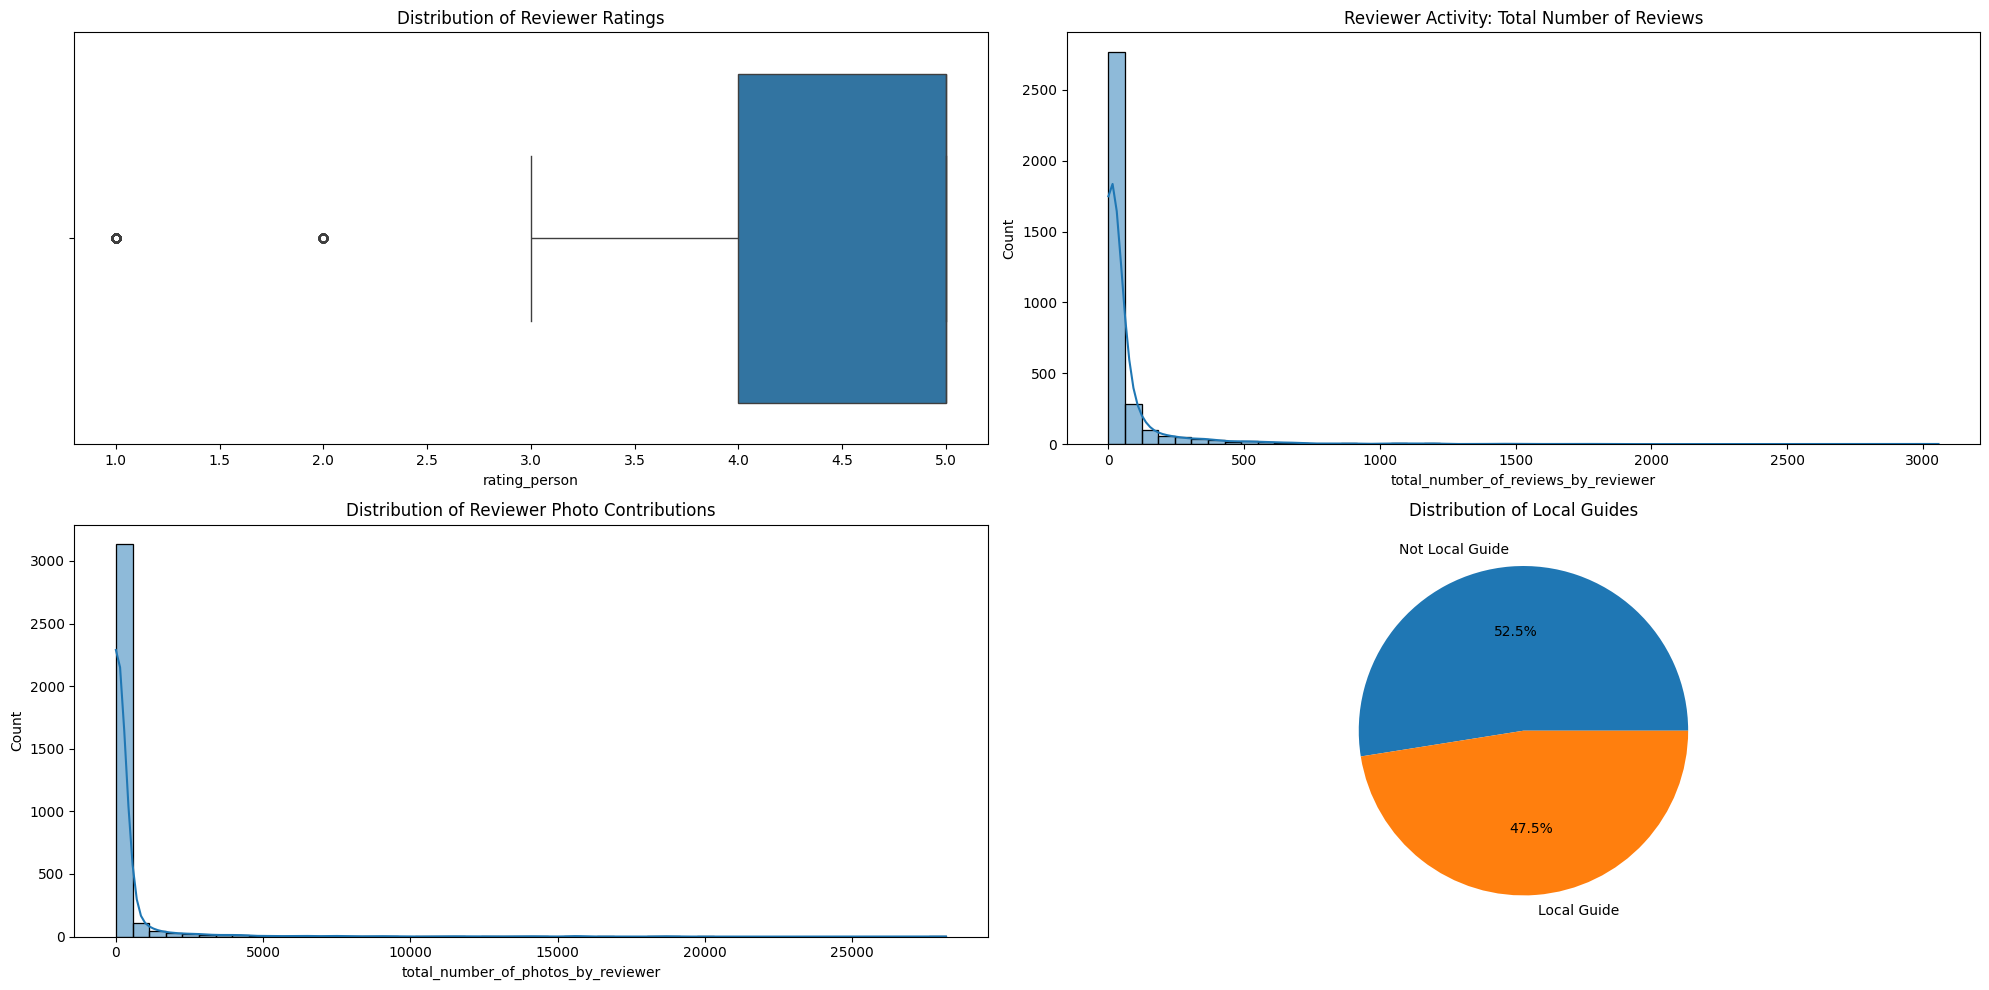

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# boxplot of reviewer ratings
sns.boxplot(x=df['rating_person'], ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Reviewer Ratings')

# Pie chart of is_local_guide
is_local_guide_counts = df['is_local_guide'].value_counts()
axs[1, 1].pie(is_local_guide_counts, labels=['Not Local Guide', 'Local Guide'], autopct='%1.1f%%')
axs[1, 1].set_title('Distribution of Local Guides')

# histogram of total_number_of_reviews_by_reviewer
sns.histplot(df['total_number_of_reviews_by_reviewer'], bins=50, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Reviewer Activity: Total Number of Reviews')

# histogram of total_number_of_photos_by_reviewer
sns.histplot(df['total_number_of_photos_by_reviewer'], bins=50, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Reviewer Photo Contributions')

fig.tight_layout()
plt.show()

### Place information

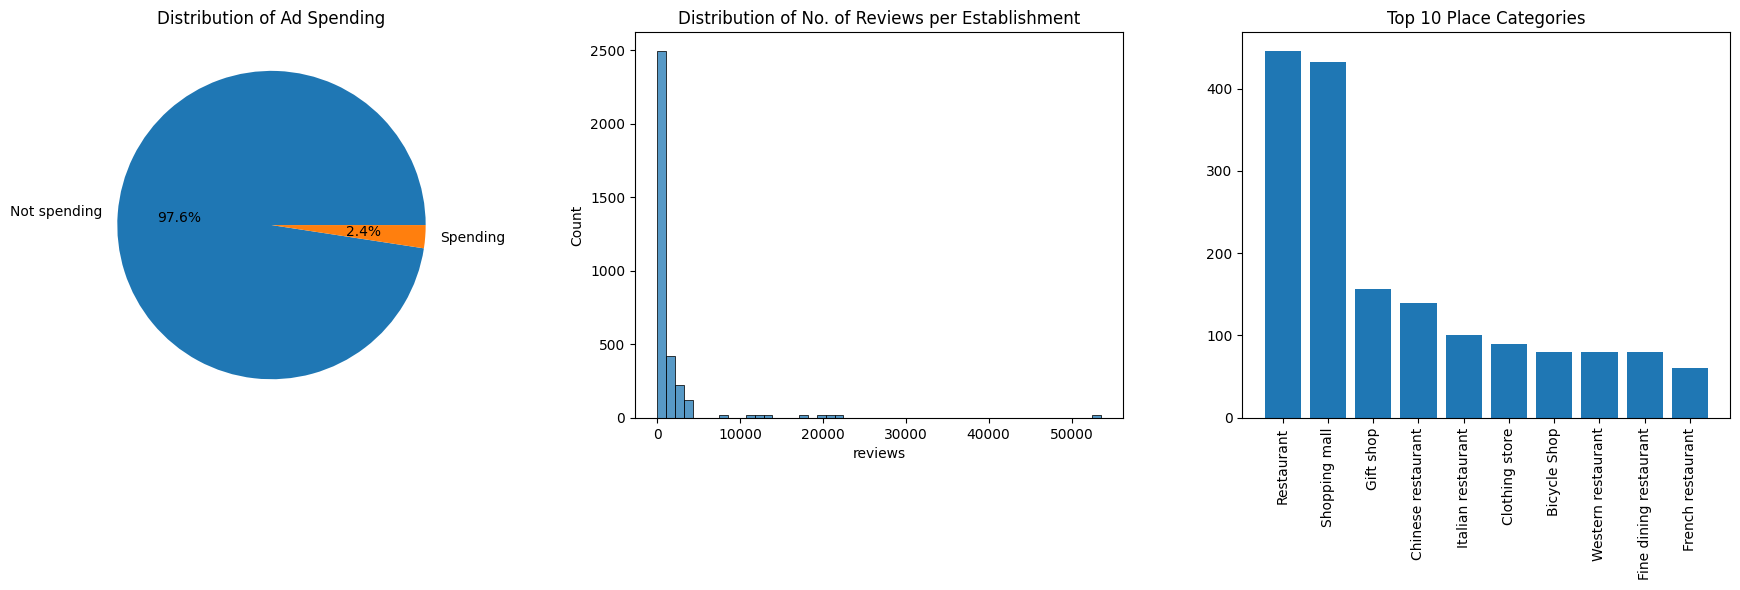

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# pie chart of is_spending_on_ads
is_spending_on_ads_counts = df['is_spending_on_ads'].value_counts()
axs[0].pie(is_spending_on_ads_counts, labels=['Not spending', 'Spending'],
           autopct='%1.1f%%')
axs[0].set_title('Distribution of Ad Spending')

# Histogram of reviews
sns.histplot(df['reviews'], bins=50, ax=axs[1])
axs[1].set_title('Distribution of No. of Reviews per Establishment')

# Bar chart of main_category
main_category_counts = df['main_category'].value_counts().head(10)
axs[2].bar(main_category_counts.index, main_category_counts.values)
axs[2].set_title('Top 10 Place Categories')
axs[2].tick_params(axis='x', rotation=90)

fig.tight_layout()

plt.show()

### Reviewer-Place Interaction

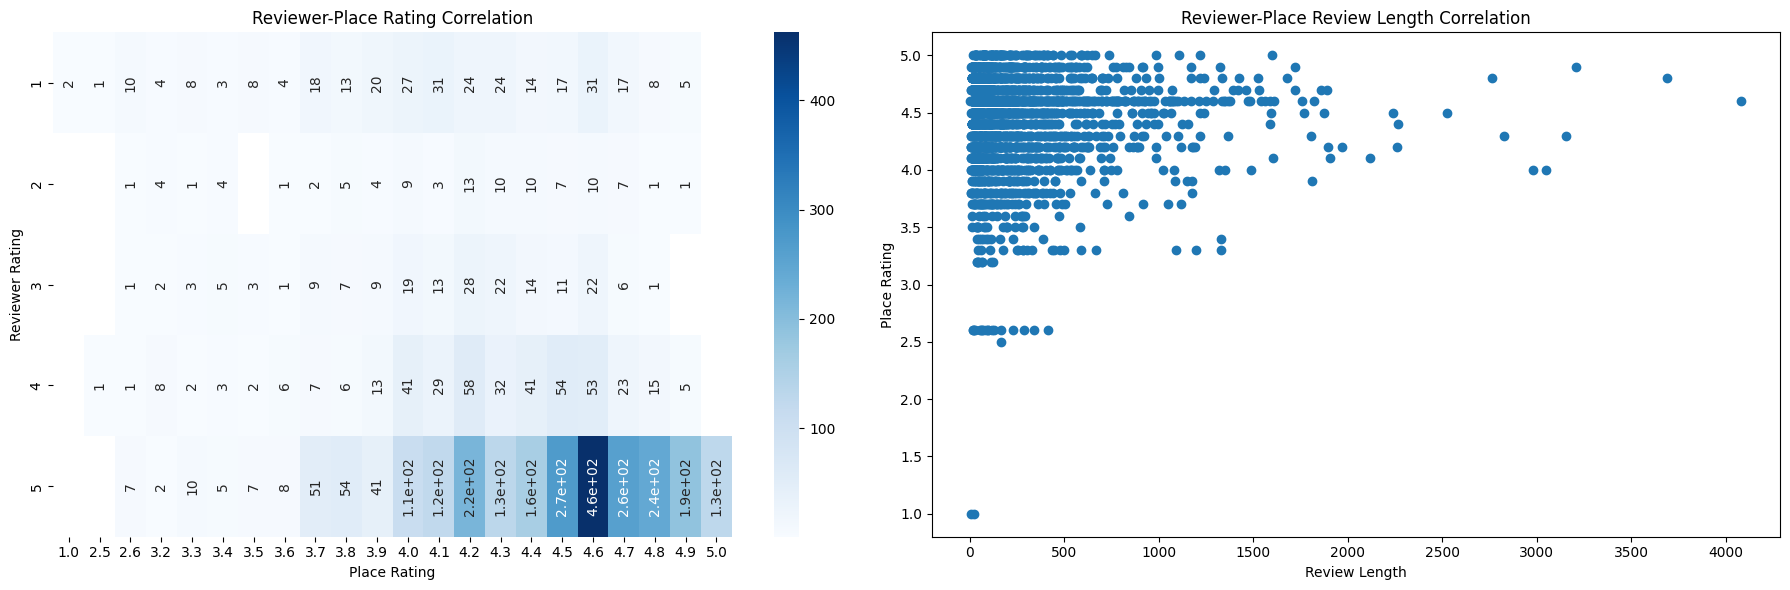

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap of rating_person vs. rating_place
rating_person_counts = df.groupby(['rating_person', 'rating_place']).size().unstack()
sns.heatmap(rating_person_counts, annot=True, annot_kws={'rotation': 'vertical'}, cmap='Blues', ax=axs[0])
axs[0].set_title('Reviewer-Place Rating Correlation')
axs[0].set_xlabel('Place Rating')
axs[0].set_ylabel('Reviewer Rating')

# Scatter plot of review text length vs. rating_place

axs[1].scatter(df['review_text'].str.len(), df['rating_place'])
axs[1].set_title('Reviewer-Place Review Length Correlation')
axs[1].set_xlabel('Review Length')
axs[1].set_ylabel('Place Rating')

fig.tight_layout()

plt.show()

### Time-based analysis

`published_at` is not very useful as is but using `published_at_date`, can create a new numerical variable `published_ago` to represent the number of days since the review was published instead.

`response_from_owner_ago` is not very use as is but using `response_from_owner_date`, can create a new numerical variable to represent the number of days since owner responded. Can use `response_from_owner_ago` as its name as it is explanatory.

In [11]:
# data scraped on 26/7/2025
df['published_at_date'] = pd.to_datetime(df['published_at_date'])
df['published_at'] = (datetime(2025, 8, 26) - df['published_at_date']).dt.days
df = df.rename(columns={'published_at': 'published_ago'})

df['response_from_owner_date'] = pd.to_datetime(df['response_from_owner_date'], errors='coerce')
df['response_from_owner_ago'] = df['response_from_owner_date'].apply(lambda x: (datetime(2025, 8, 26) - x).days if not pd.isnull(x) else None)
df.drop(columns=['published_at_date', 'response_from_owner_date'], inplace=True)


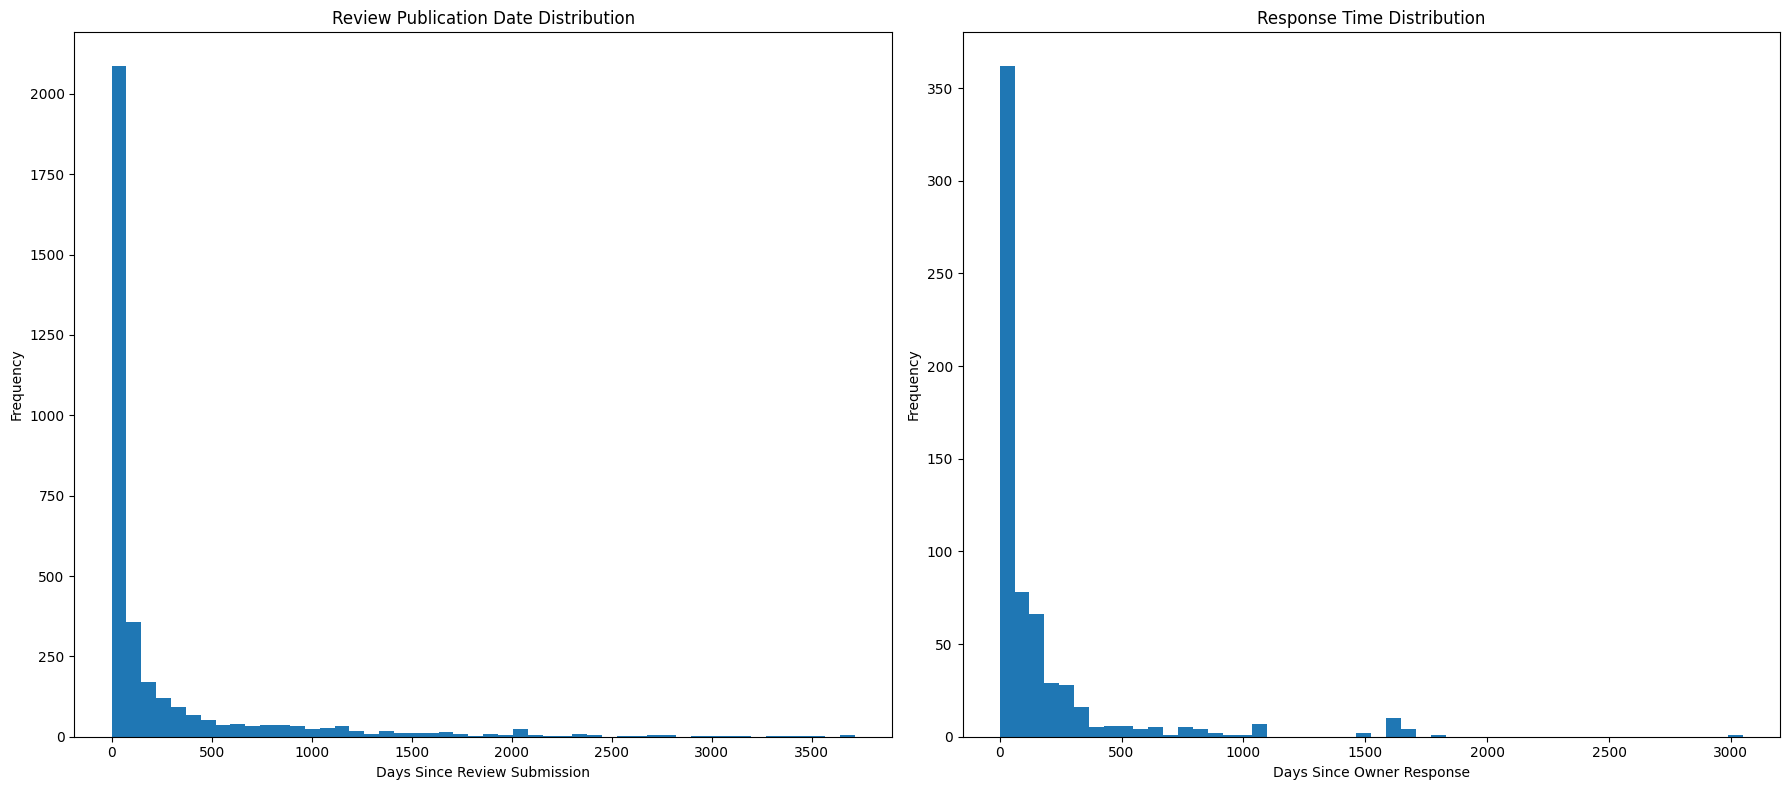

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Histogram of published_at
axs[0].hist(df['published_ago'], bins=50)
axs[0].set_title('Review Publication Date Distribution')
axs[0].set_xlabel('Days Since Review Submission')
axs[0].set_ylabel('Frequency')

# Histogram of response_from_owner_ago
axs[1].hist(df['response_from_owner_ago'], bins=50)
axs[1].set_title('Response Time Distribution')
axs[1].set_xlabel('Days Since Owner Response')
axs[1].set_ylabel('Frequency')

fig.tight_layout()

plt.show()

## Correlation matrix of numeric variables

Using non-boolean numeric variables

                                     rating_person  published_ago  \
rating_person                             1.000000      -0.085200   
published_ago                            -0.085200       1.000000   
total_number_of_reviews_by_reviewer      -0.003629       0.080244   
total_number_of_photos_by_reviewer       -0.004454       0.070303   
reviews                                   0.002006      -0.042812   
rating_place                              0.331195      -0.192559   

                                     total_number_of_reviews_by_reviewer  \
rating_person                                                  -0.003629   
published_ago                                                   0.080244   
total_number_of_reviews_by_reviewer                             1.000000   
total_number_of_photos_by_reviewer                              0.701788   
reviews                                                        -0.020235   
rating_place                                                

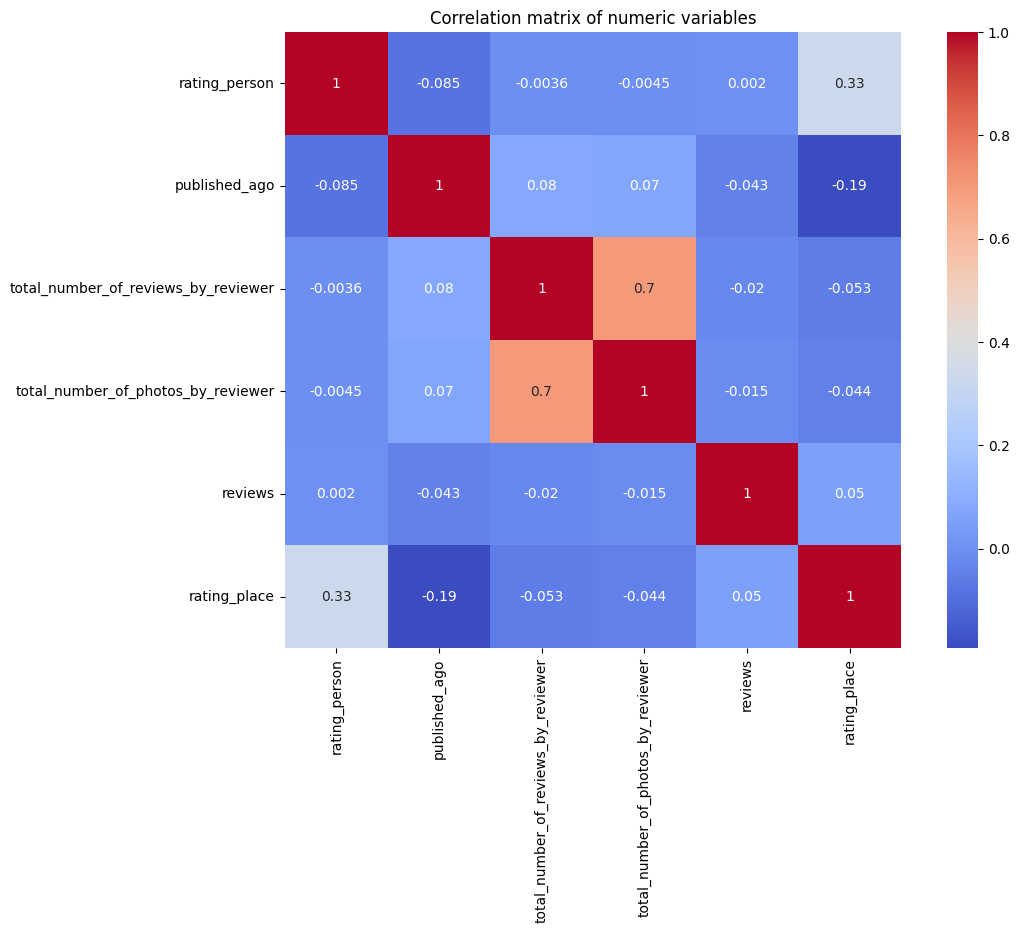

In [13]:
# excluded response_from_owner_date because it is not numerical for all its values (contains NaN)
corr_matrix_num = df[['rating_person', 'published_ago', 'total_number_of_reviews_by_reviewer', 
                      'total_number_of_photos_by_reviewer', 'reviews', 'rating_place']].corr()

print(corr_matrix_num)

# Heatmap of corr matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_num, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation matrix of numeric variables')
plt.show()

Could possibly choose either total number of photos or total number of reviews to drop as they are correlated.

In [14]:
# Tentative column drop
tentative_drop_cols = ['name_place', 'response_from_owner_text', 'experience_details', 'description', 'competitors', 'workday_timing', 'closed_on',
                       'address', 'review_keywords', 'published_ago', 'response_from_owner_ago', 'categories']
df.drop(columns=[c for c in tentative_drop_cols if c in df.columns], inplace=True, errors="ignore")

# Feature Engineering for categorical variables

# Labelled Data Analysis

In [ ]:
labelled_df = pd.read_csv('../data/cleaned_labelled_data.csv')

In [16]:
# for categorical
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Text feature engineering
def add_text_features(df, text_col="review_text"):
    df = df.copy()
    df["text_length_words"] = df[text_col].fillna("").apply(lambda x: len(x.split()))
    df["sentiment_polarity"] = df[text_col].fillna("").apply(lambda x: TextBlob(x).sentiment.polarity)
    df["sentiment_subjectivity"] = df[text_col].fillna("").apply(lambda x: TextBlob(x).sentiment.subjectivity)
    return df

# Main association function
def association_with_label(df, label_col, numeric_cols, categorical_cols, text_col="review_text"):
    results = []

    # Numeric features
    for col in numeric_cols:
        groups = [df[df[label_col]==cls][col].dropna() for cls in df[label_col].unique()]
        if len(groups) > 1:
            stat, p = f_oneway(*groups)
            results.append({"feature": col, "type": "numeric", "score": stat, "p_value": p})

    # Categorical features
    for col in categorical_cols:
        try:
            v = cramers_v(df[label_col], df[col])
            results.append({"feature": col, "type": "categorical", "score": v, "p_value": None})
        except:
            pass

    # Text-derived features
    df_text = add_text_features(df, text_col=text_col)
    text_features = ["text_length_words","sentiment_polarity","sentiment_subjectivity"]
    for col in text_features:
        groups = [df_text[df_text[label_col]==cls][col].dropna() for cls in df_text[label_col].unique()]
        if len(groups) > 1:
            stat, p = f_oneway(*groups)
            results.append({"feature": col, "type": "text-derived", "score": stat, "p_value": p})

    return pd.DataFrame(results).sort_values(by="score", ascending=False).reset_index(drop=True)

# Columns
numeric_cols = [
    'rating_person', 'rating_place', 
    'total_number_of_reviews_by_reviewer', 
    'total_number_of_photos_by_reviewer', 
    'reviews'
]

categorical_cols = [
    'main_category', 'is_local_guide', 
    'is_spending_on_ads', 'can_claim'
]

assoc = association_with_label(labelled_df, label_col="label",
                               numeric_cols=numeric_cols,
                               categorical_cols=categorical_cols,
                               text_col="review_text")

# Normalize numeric/text-derived features
mask_num_text = assoc['type'].isin(['numeric','text-derived'])
max_score = assoc.loc[mask_num_text,'score'].max()
assoc.loc[mask_num_text,'scaled_score'] = assoc.loc[mask_num_text,'score'] / max_score

# Keep categorical scores as is
mask_cat = assoc['type'] == 'categorical'
assoc.loc[mask_cat,'scaled_score'] = assoc.loc[mask_cat,'score']

# Sort by scaled_score
assoc_sorted = assoc.sort_values(by='scaled_score', ascending=False).reset_index(drop=True)
print(assoc_sorted[['feature','type','scaled_score']])

                                feature          type  scaled_score
0                sentiment_subjectivity  text-derived      1.000000
1                         rating_person       numeric      0.358509
2                    sentiment_polarity  text-derived      0.314800
3                         main_category   categorical      0.194307
4                             can_claim   categorical      0.181172
5                     text_length_words  text-derived      0.142845
6                        is_local_guide   categorical      0.052361
7                          rating_place       numeric      0.040581
8                    is_spending_on_ads   categorical      0.034776
9                               reviews       numeric      0.019702
10  total_number_of_reviews_by_reviewer       numeric      0.007217
11   total_number_of_photos_by_reviewer       numeric      0.000607


If model takes too long to train, might want to cut down to the top 5 features instead.